# Code Objective:

*   Ensemble from BERT and XLMRoberta Prediction Probabilities to Enhance Performance of Coarse Grained Evaluation

# Code Result:
*   (Previous) Accuracy - BERT Model for Coarse Grained Evaluation = 91.63 %
*   (Previous) Accuracy - XLMRoBerta for Coarse Grained Evaluation = 89.76 %
*   Accuracy - Ensemble (BERT+Roberta) for Coarse Grained Evaluation = 92.60 %





# Importing Libraries

In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dropout, Dense, Add, Multiply, Average, Concatenate, Input, Subtract

# Data Loading

In [ ]:
path = '/content/'

# Probability Data Loading
x_train_1 = np.load(path + 'Train_Probs_Bert.npy', allow_pickle = True)
x_train_1 = x_train_1[:,:2]
x_test_1 = np.load(path + 'Test_Probs_Bert.npy', allow_pickle = True)
x_test_1 = x_test_1[:,:2]
x_train_2 = np.load(path + 'Train_Probs_XLMR.npy', allow_pickle = True)
x_test_2 = np.load(path + 'Test_Probs_XLMR.npy', allow_pickle = True)
y_train = np.load(path + 'Train_Labels.npy', allow_pickle = True)
y_test = np.load(path + 'Test_Labels.npy', allow_pickle = True)

print("X Train Prob BERT Size = {}".format(x_train_1.shape)) 
print("X Test Prob BERT Size = {}".format(x_test_1.shape))
print("X Train Prob XLMR Size = {}".format(x_train_2.shape))
print("X Train Prob XLMR Size = {}".format(x_test_2.shape))
print("Y Train Label Size = {}".format(y_train.shape))
print("Y Test Label Size = {}".format(y_test.shape))

# Ensemble Architecture (BERT and XLMRoberta)

In [ ]:
# Input Placeholders
input_1 = Input(shape = (2,))
input_2 = Input(shape = (2,))

# Ensemble Model Archirecture
def Classifier_Top(input_1,input_2):
    activation = 'tanh'
    z1 = Dense(units = 50, activation = activation)(input_1)
    z1 = Dropout(0.2)(z1)
    z2 = Dense(units = 50, activation = activation)(input_2)
    z2 = Dropout(0.2)(z2)
    z = Concatenate()([z1,z2])
    z = Dense(units = 30, activation = activation)(z)
    z = Dropout(0.2)(z)
    z = Dense(units = 20, activation = activation)(z)
    z = Dropout(0.2)(z)
    z = Dense(units = 10, activation = activation)(z)
    z = Dropout(0.2)(z)
    z = Dense(units = 5, activation = activation)(z)
    z = Dropout(0.2)(z)
    output = Dense(units = 1, activation = 'sigmoid')(z)
    model = Model(inputs = [input_1,input_2], outputs = output)
    model.summary()
    return model 

# Compile and Train Model
def compile_and_train(model, num_epochs): 
    model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics=['acc']) 
    history = model.fit([x_train_1,x_train_2], y_train, batch_size=32, epochs=num_epochs, validation_split=0.2)
    return history

# Training and Evaluation

In [ ]:
Epochs = 10                                     # Training Iteration Number
Classifier = Classifier_Top(input_1,input_2)
history = compile_and_train(Classifier,Epochs)

In [ ]:
# For Loading Already Finetuned Model
Classifier = Classifier_Top(input_1,input_2)
Classifier.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics=['acc'])
Classifier.load_weights('content/Task_1_Best.h5') # Load the Weight into colab local directory first

# Evaluation

In [ ]:
test_scores = Classifier.evaluate([x_test_1,x_test_2], y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

# Model Save

In [ ]:
Classifier.save_weights("Task_1_Best.h5")

# Visualization of Test Result (Coarse Grained Evaluation)

In [ ]:
# Code for Changing 
def pred_to_lab(y_pred_probs, mode):
  labels = []
  for i in y_pred_probs:
    if i<0.5:
      if mode == 'Num':
        labels.append(0)
      elif mode == 'Text':
        labels.append('non-hostile')
    else:
      if mode == 'Num':
        labels.append(1)
      elif mode == 'Text':
        labels.append('hostile')
  if mode == 'Num':
    return np.array(labels)
  elif mode == 'Text':
    return labels

y_pred_probs = Classifier.predict([x_test_1,x_test_2])

y_pred = pred_to_lab(y_pred_probs, mode = 'Num')
print(y_pred)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       435
           1       0.93      0.91      0.92       376

    accuracy                           0.93       811
   macro avg       0.93      0.93      0.93       811
weighted avg       0.93      0.93      0.93       811



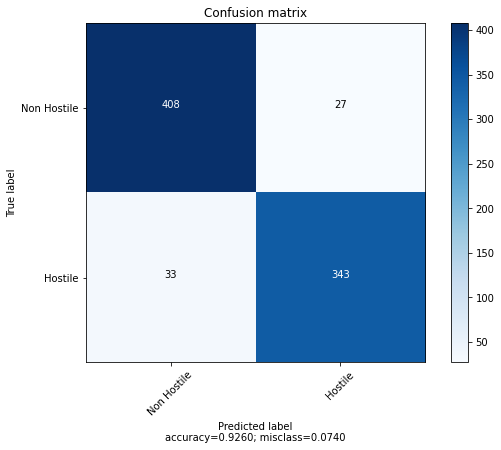

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

print(classification_report(y_test,y_pred))
target_names = ['Non Hostile','Hostile']
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names)

In [ ]:
# Saving Predicted Labels of Coarse Grained Evaluation
np.save("Task_1_Pred_Labels.npy",y_pred)